# Cat and Dog Classification using Convolutional Neural Networks

### by: Valentina Angelovska
________________________

### About Dataset:

This dataset consists of 25,000 labeled images intended for training. To optimize the process, I will shuffle the dataset and select 20,000 images for training, 5000 for validation. Additionally, I will upload a separate set of unlabeled images as files_test to test the model performence.


In [1]:
# Importing necessary libraries

# Basic libraries
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from collections import Counter
import pickle
import os

# Image/Visualization
import matplotlib.pyplot as plt
import glob
import cv2
import pathlib

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

# Keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Randomize
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Connecting with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [4]:
# Get files path
files_train = glob.glob('/content/drive/MyDrive/train/*.*')
files_test = glob.glob('/content/drive/MyDrive/test_sampled/*.*')

print('Number of train files:', len(files_train))
print('Number of test files:', len(files_test))

Number of train files: 25029
Number of test files: 576


In [24]:
# Define Function to read image and preprocess
def read_data(files, return_labels=True):

    # Initialize dataset
    dataset = np.zeros((len(files), width, height, 3), dtype=np.float32)
    labels = [] if return_labels else None

    # Load and preprocess images
    for i, filep in enumerate(tqdm(files, desc="Processing Images")):
        image = cv2.imread(filep, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = cv2.resize(image, dsize=(height, width))
        image /= 255.0
        dataset[i] = image

        if return_labels:
            split_file = filep.split('/')[-1]
            label = split_file.split('.')[0]
            labels.append(label)

    if return_labels:
        return dataset, labels
    else:
        return dataset

In [26]:
# Shuffle image paths
random.shuffle(files_train)

# Size of image
width = 80
height = 100

# Load datasets
X_train, y_train = read_data(files_train[:20000])
X_valid,y_valid = read_data(files_train[20000:])
X_test = read_data(files_test, return_labels = False)

Processing Images: 100%|██████████| 576/576 [03:10<00:00,  3.02it/s]


In [27]:
# Checking labels
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_train

array(['cat', 'dog', 'cat', ..., 'cat', 'dog', 'cat'], dtype='<U3')

In [28]:
# Shapes
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (20000, 80, 100, 3)
y_train shape: (20000,)
X_valid shape: (5029, 80, 100, 3)
y_valid shape: (5029,)
X_test shape: (576, 80, 100, 3)


In [29]:
print('Class label in train:', Counter(y_train))
print('Class label in valid:', Counter(y_valid))

Class label in train: Counter({'dog': 10033, 'cat': 9967})
Class label in valid: Counter({'cat': 2553, 'dog': 2476})


# Visualization

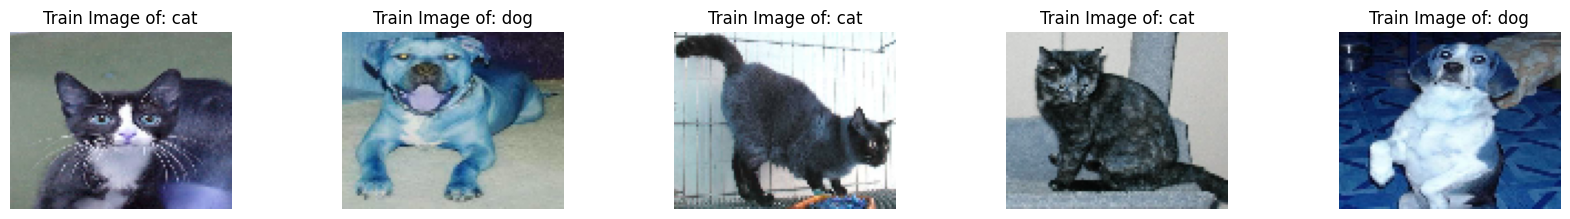

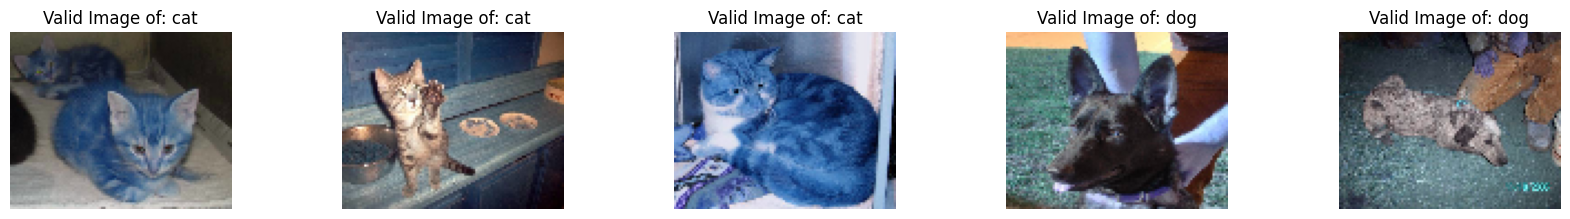

In [30]:
# Checking if image match the class

def plot_images(images, labels, title_prefix, num_images=10):
    plt.figure(figsize=(20, 5))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'{title_prefix} {labels[i]}', fontsize=12)
        plt.axis('off')

    plt.show()

# Plotting training images
plot_images(X_train, y_train, 'Train Image of:', num_images=5)

# Plotting validation images
plot_images(X_valid, y_valid, 'Valid Image of:', num_images=5)


In [31]:
# Encoding

label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# ohe
# num_classes = 2
# y_train_encoded = to_categorical(y_train_encoded)
# y_valid_encoded = to_categorical(y_valid_encoded)


# Model Training


In [32]:
# Define Model
model = Sequential()

# Input Layer
model.add(Input((80,100,3)))

# Convolutional Layer
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))

# Flatten
model.add(Flatten())

# Fully Conected Layer
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 32, activation = 'relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
# Train model
es_cbk = EarlyStopping(patience=5, monitor='val_loss',min_delta = 0.005, restore_best_weights=True)

model_history = model.fit(X_train,
                          y_train_encoded,
                          validation_data=(X_valid, y_valid_encoded),
                          epochs=200,
                          batch_size=64,
                          callbacks=[es_cbk])

Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 77ms/step - accuracy: 0.5138 - loss: 0.6979 - val_accuracy: 0.5675 - val_loss: 0.6764
Epoch 2/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.5653 - loss: 0.6798 - val_accuracy: 0.6015 - val_loss: 0.6606
Epoch 3/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6169 - loss: 0.6551 - val_accuracy: 0.6494 - val_loss: 0.6332
Epoch 4/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.6553 - loss: 0.6221 - val_accuracy: 0.6872 - val_loss: 0.5873
Epoch 5/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.6999 - loss: 0.5786 - val_accuracy: 0.7151 - val_loss: 0.5619
Epoch 6/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7344 - loss: 0.5299 - val_accuracy: 0.7347 - val_loss: 0.5406
Epoch 7/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.7688 - loss: 0.4827 - val_accuracy: 0.7502 - val_loss: 0.5158
Epoch 8/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.8051 - loss: 0

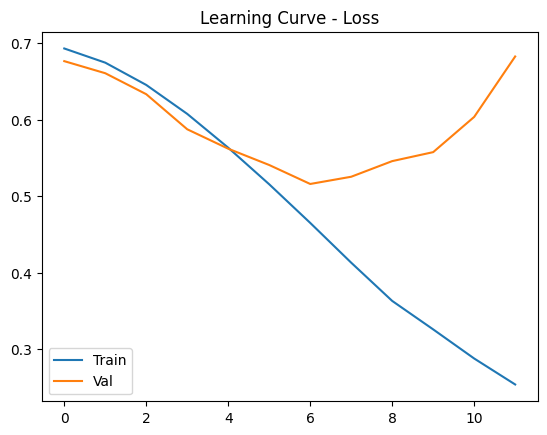

In [34]:
# Plot learning curve for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Learning Curve - Loss')
plt.legend(['Train', "Val"])

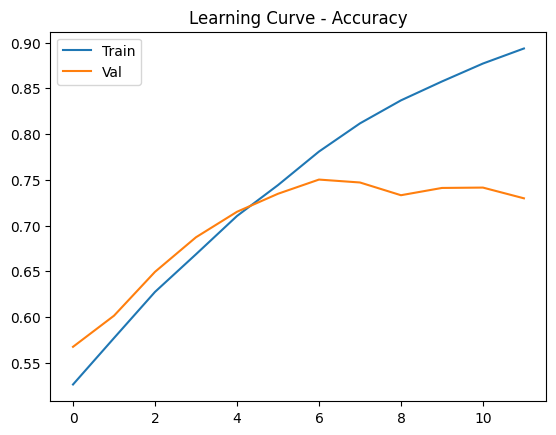

In [35]:
# Plot learning curve for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Learning Curve - Accuracy')
plt.legend(['Train', "Val"])

### Prediction using unseen and unlabeled data from test files

In [47]:
# Predict
np.random.shuffle(X_test)
y_pred = model.predict(X_test).round(0)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


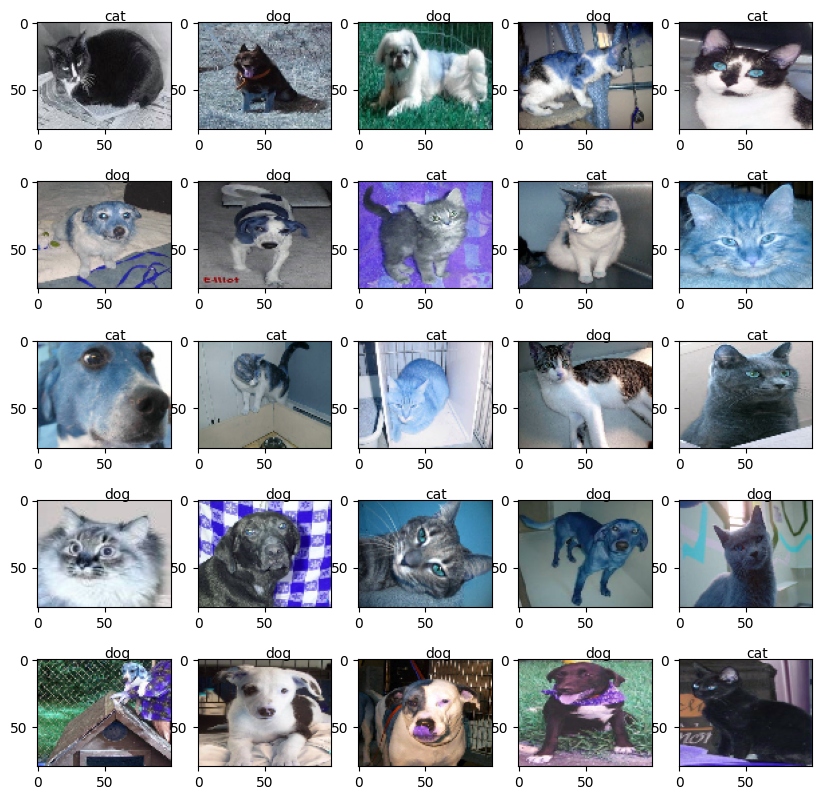

In [50]:
# Plot prediction
fig = plt.figure(figsize=(10,10))
for i in range(5*5):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(X_test[i])
    title = 'dog' if y_pred[i] == 1 else 'cat'
    ax.text(50, -1.5, title, size=10)

## Conclusion:

The model's performance was suboptimal, with several errors observed.

# Using Data Augmentation

Data augmentation will generate images that are rotated, shifted, zoomed, flipped, and more. Since each image can be viewed from different angles, increasing the variety of images available to the model will enhance its ability to perform accurately.

In [62]:
# Define
datagen = ImageDataGenerator(
        rotation_range=100,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


datagen.fit(X_train)
datagen

In [61]:
# Training model
es_cbk = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

model_history1 = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=64),
                            epochs=300,
                            validation_data=(X_valid, y_valid_encoded),
                            callbacks=[es_cbk])

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 212ms/step - accuracy: 0.6383 - loss: 0.6462 - val_accuracy: 0.7329 - val_loss: 0.5465
Epoch 2/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 217ms/step - accuracy: 0.6759 - loss: 0.6056 - val_accuracy: 0.7009 - val_loss: 0.5740
Epoch 3/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.6871 - loss: 0.5923 - val_accuracy: 0.7353 - val_loss: 0.5472
Epoch 4/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - accuracy: 0.6925 - loss: 0.5902 - val_accuracy: 0.7377 - val_loss: 0.5357
Epoch 5/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 176ms/step - accuracy: 0.6965 - loss: 0.5781 - val_accuracy: 0.7542 - val_loss: 0.5320
Epoch 6/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.6990 - loss: 0.5807 - val_accuracy: 0.7528 - val_loss: 0.5283
Epoch 7/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 163ms/step - accuracy: 0.7076 - loss: 0.5746 - val_accuracy: 0.7596 - val_loss: 0.5146
Epoch 8/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 159ms/step - accuracy: 0.7099 - loss: 0.572

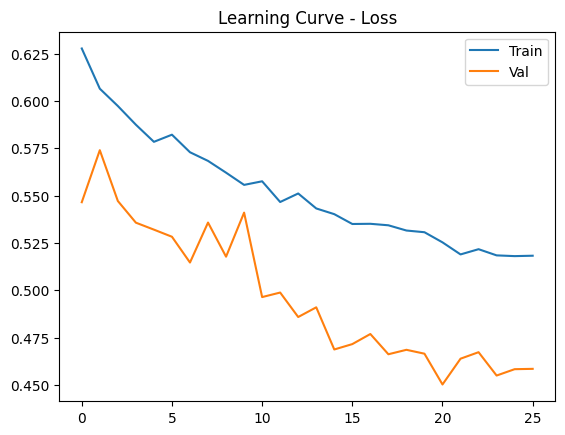

In [63]:
# Plot loss
plt.plot(model_history1.history['loss'])
plt.plot(model_history1.history['val_loss'])
plt.title('Learning Curve - Loss')
plt.legend(['Train', "Val"])
plt.show()

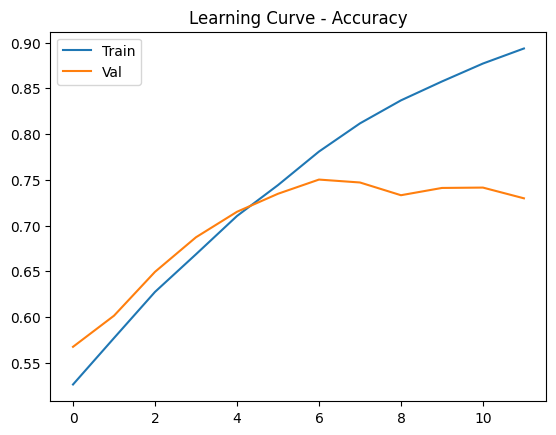

In [64]:
# Plot accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Learning Curve - Accuracy')
plt.legend(['Train', "Val"])
plt.show()

# Prediction

**Prediction will be made using unlabeled data from files_test**

In [69]:
# Predict
np.random.shuffle(X_test)

y_pred_aug = model.predict(X_test).round(0)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


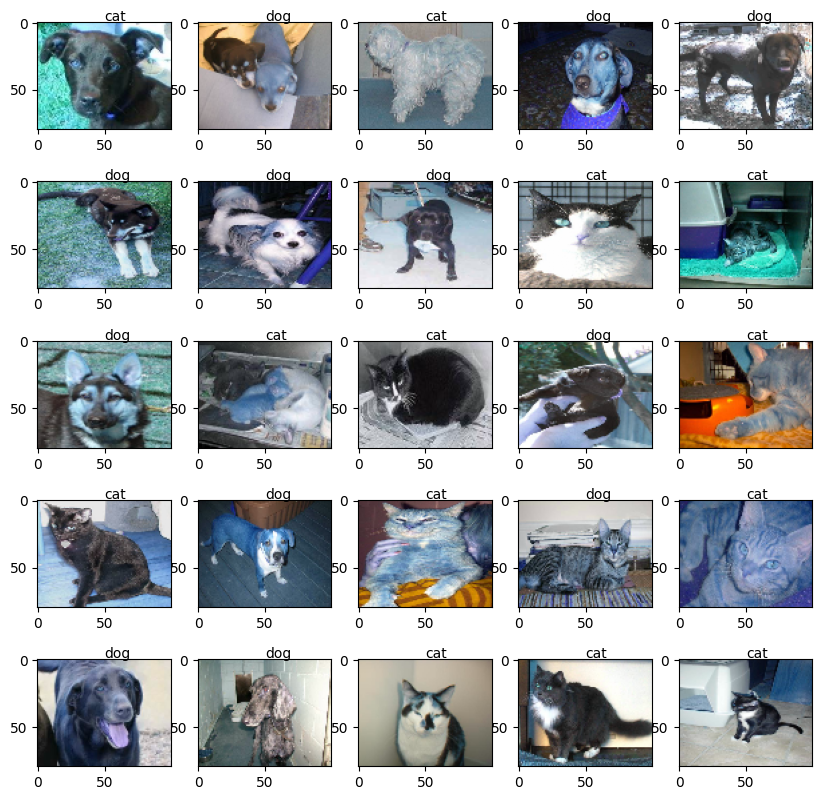

In [70]:
# Plot predictions
fig = plt.figure(figsize=(10,10))
for i in range(5*5):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(X_test[i])
    title = 'dog' if y_pred_aug[i] == 1 else 'cat'
    ax.text(50, -1.5, title, size=10)

# Final Conclusion

Slightly better results were achieved with data augmentation, but due to the limited number of images, the accuracy remains around 70-80%. With more training images, the model's accuracy could improve further. However, due to GPU limitations, these are the best results obtained so far.